# SVM (Support Vector Machines)


## Objectives

After completing this lab you will be able to:

*   Use scikit-learn to Support Vector Machine to classify

In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [1]:
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv('cell_samples.csv')
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
<br>

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.

**Did you know?** When it comes to Machine Learning, you will likely be working with large datasets. As a business, where can you host your data? IBM is offering a unique opportunity for businesses, with 10 Tb of IBM Cloud Object Storage: [Sign up now for free](http://cocl.us/ML0101EN-IBM-Offer-CC)


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Let's look at the distribution of the classes based on Clump thickness and Uniformity of cell size:


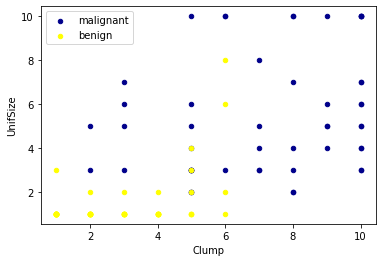

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

ax=df[df['Class']==4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant')
df[df['Class']==2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax)
plt.show()

## Data pre-processing and selection

In [16]:
#examining the datatypes of the column

df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the **BareNuc** column includes some values that are not numerical. We can drop those rows:


In [18]:
df=df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc']=df['BareNuc'].astype('int')
df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [19]:
# defining X

In [20]:
df.columns

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

In [21]:
feature_df = df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]

In [22]:
X = np.asanyarray(feature_df)

In [23]:
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [24]:
df['Class']=df['Class'].astype('int')
y = np.asanyarray(df['Class'])
y[0:5]

array([2, 2, 2, 2, 2])

In [25]:
y.shape[0]

683

## Train/Test dataset

We split our dataset into train and test set:

In [27]:
import sklearn
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)
print('Train set: ', X_train.shape[0], y_train.shape[0])
print('Test set: ', X_test.shape[0], y_test.shape[0])

Train set:  546 546
Test set:  137 137


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset. We usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


In [29]:
from sklearn import svm
clf=svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

After fitting, the model can then be used to predict values

In [30]:
yhat=clf.predict(X_test)
yhat[0:5]

array([2, 4, 2, 4, 2])

In [32]:
y_test[0:5]

array([2, 4, 2, 4, 2])

## Evaluation

In [33]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [44]:
def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize: 
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix without Normalization')
    
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt='.2f' if normalize else 'd'
    thresh = cm.max()/2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment = 'center',
                color='white' if cm[i,j]>thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [42]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137



Confusion Matrix without Normalization
[[85  5]
 [ 0 47]]


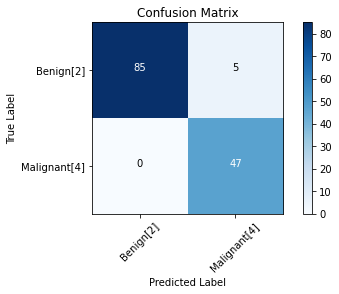

In [72]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign[2]', 'Malignant[4]'], normalize=False, title='Confusion Matrix')

You can also easily use the **f1\_score** from sklearn library:

In [46]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.9639038982104676

Let's try jaccard score

In [47]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat, pos_label=2)

0.9444444444444444

<h2 id="practice">Practice</h2>
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?

In [48]:
## to practice with other kernels

### Practice with Standardized/Normalized data Dataset

In [49]:
df_n = pd.read_csv('cell_samples.csv')
df_n.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [50]:
df_n.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

In [52]:
# cleaning BareNuc
df_n=df_n[pd.to_numeric(df_n['BareNuc'], errors='coerce').notnull()]
df_n['BareNuc'] = df_n['BareNuc'].astype('int')
df_n.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [53]:
df_n.columns

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

In [56]:
# Let's normalize X
from sklearn.preprocessing import StandardScaler

In [57]:
X=df_n[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = StandardScaler().fit(X).transform(X)
X[0:4]

array([[ 0.2 , -0.7 , -0.74, -0.64, -0.56, -0.7 , -0.18, -0.61, -0.35],
       [ 0.2 ,  0.28,  0.26,  0.76,  1.7 ,  1.77, -0.18, -0.29, -0.35],
       [-0.51, -0.7 , -0.74, -0.64, -0.56, -0.42, -0.18, -0.61, -0.35],
       [ 0.55,  1.58,  1.6 , -0.64, -0.11,  0.13, -0.18,  1.35, -0.35]])

In [65]:
y=np.asanyarray(df_n['Class'].astype('int'))
y[0:4]

array([2, 2, 2, 2])

## Train/Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4)
X_train.shape

(546, 9)

## Build the model

In [83]:
svm_mod = svm.SVC(kernel='rbf').fit(X_train, y_train)
svm_mod

SVC()

## Predict

In [84]:
yhat = svm_mod.predict(X_test)

In [85]:
print(y_test[0:4])
print(yhat[0:4])

[2 4 2 4]
[2 4 2 4]


Confusion Matrix without Normalization
[[85  5]
 [ 0 47]]


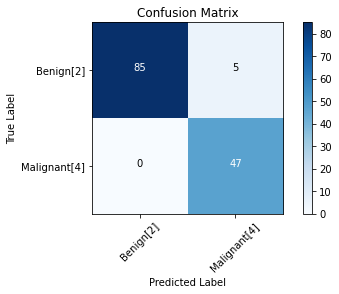

In [86]:
## plot confusion matrix

# 1. Compute confusion matrix
cm = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

# 2. Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['Benign[2]', 'Malignant[4]'], normalize=False, title='Confusion Matrix')

In [88]:
print(jaccard_score(yhat, y_test, pos_label=2))
print(f1_score(yhat, y_test, average='weighted'))

0.9444444444444444
0.9631034010596053


## Predicting with other kernels

In [77]:
kn = ['linear', 'poly', 'rbf', 'sigmoid']
scores_list=[]

for k in kn:
    svm_mod = svm.SVC(kernel=k).fit(X_train, y_train)
    yhat = svm_mod.predict(X_test)
    js=jaccard_score(y_test, yhat, pos_label=2)
    fs = f1_score(y_test, yhat, average='weighted')
    scores_list.append((k, js, fs))

scores_list

[('linear', 0.9444444444444444, 0.9639038982104676),
 ('poly', 0.967032967032967, 0.9781562743461025),
 ('rbf', 0.9444444444444444, 0.9639038982104676),
 ('sigmoid', 0.9444444444444444, 0.9639038982104676)]